<a href="https://colab.research.google.com/github/DenisseUrenda/MachineLearning/blob/main/L05_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $K$ - nearest neighbors

## Introducción

El algoritmo KNN ($K$ - nearest neighbors) es de aprendizaje supervisado que puede ser usado tanto para clasificación como para regresión. Se basa en los valores que tienen sus $K$ vecinos más cercanos con base en una medida de distancia $d$.

- **Regresión**: toma el promedio de las etiquetas de estos $K$ vecinos como la predicción del nuevo punto.
- **Clasificación**: toma la moda de las etiquetas de estos $K$ vecinos como la predicción dle nuevo punto.

La medida de distancia más comúnmente utilizada es la distancia euclideana
$$
d_2(\textbf x,\textbf y) = \sqrt{\sum_{i=1}^n(x_i-y_i)^2}
$$

Otra medida es la conocida como distancia Manhattan
$$
d_1(\textbf x, \textbf y) = \sum_{i=1}^n|x_i-y_i|
$$

Aquí $\textbf x = (x_1,...,x_n)^T$ y $\textbf y = (y_1,...,y_n)^T$.

La distancia de Minkowski de orden $p$ es la generalización de las distancias anteriores
$$
d_p(\textbf x, \textbf y)=\left(\sum_{i=1}^n|x_i-y_i|^p \right)^{1/p }
$$
para $p\geq1$.

Cuando $p\rightarrow \infty$, $d_p(\textbf x, \textbf y)\rightarrow \max_{i=1,\cdots,n}|x_i-y_i|$

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

En el siguiente código crearemos el conjunto de datos que usaremos para la clasificación con KNN.

In [ ]:
grupo1 = np.random.multivariate_normal(mean = [2,   1], cov = [[1, -0.5], [-0.5, 1]], size = 150)
grupo2 = np.random.multivariate_normal(mean = [2.5, 2], cov = [[1, 0.7], [0.7, 1]], size = 200)
X = np.concatenate((grupo1, grupo2), axis = 0)
y = np.repeat([1, 2], repeats=[150, 200])

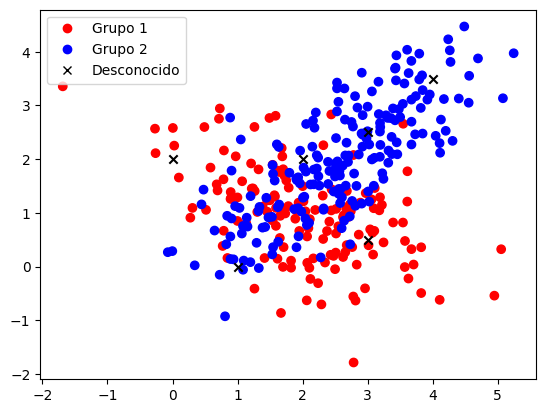

In [ ]:
A = np.array([[0, 2], [3, 0.5], [4, 3.5], [1, 0], [2, 2], [3, 2.5]])

plt.scatter(X[:,0], X[:,1], c=['r' if a == 1 else 'b' for a in y])
plt.scatter(A[:,0], A[:,1], c='k', marker='x')
custom_legend = [
    plt.Line2D([], [], marker='o', color='r', label='Grupo 1', linestyle=''),
    plt.Line2D([], [], marker='o', color='b', label='Grupo 2', linestyle=''),
    plt.Line2D([], [], marker='x', color='k', label='Desconocido', linestyle='')
]
plt.legend(handles=custom_legend)
plt.show()

Crearemos varias funciones para predecir la etiqueta de cada valor nuevo que introduzcamos al modelo.

- `distance()`: estan función calcula la distancia de un punto en particular `x` a cada renglón del conjunto de datos `df`. Se puede especificar la distancia euclidiana, manhattan o cualquier otra de minkowski.

- `knearest()`: regresa un arreglo unidimensional con los índices de los k valores más pequeños.

- `single_prediction()`: regresa la predicción de un punto particular. Esta usa las funciones anteriores internamente. Primero calcula la distancia del punto a los puntos del conjunto de datos, luego pasa este resultado a la función `knearest` para calcular los índices de sus vecinos más cercanos. Calcula el promedio (regresión) o la moda (clasificación) de los valores de respuesta correspondientes a los k vecinos.

- `predict()`: con esta función se puede predecir más de un solo valor a la vez. Esta usa la función `single_prediction` y regresa un arreglo unidimensional con las predicciones.

No es necesario usar las cuatro funciones para hacer una predicción, estas fueron creadas para ser usadas por `predict()` por lo que basta con usar únicamente esta última.

In [ ]:
def distance(df, x, dist='euclidean', p=None):
  dist_names = {'manhattan': 1, 'euclidean': 2, 'minkowski': p}
  p = dist_names.get(dist, 2)
  res = (df.sub(x, axis='columns').abs()**p).sum(axis=1)**(1/p)
  return res


def knearest(df, k=5):
  res = df.sort_values()[:k].index
  return res.to_numpy()


def single_prediction(X, y, newx, k=5, regression=True, dist='euclidean'):
  newx = np.array(newx)
  dis = distance(pd.DataFrame(X), newx, dist=dist)
  idx = knearest(dis, k=k)
  if regression: pred = pd.DataFrame(y).iloc[idx].mean()
  else: pred = pd.DataFrame(y).iloc[idx].mode()[0]
  return pred.to_numpy()


def predict(X, y, newX, k=5, regression=True, dist='euclidean'):
  preds = [single_prediction(X, y, x, k=k, regression=regression, dist=dist)[0] for x in newX]
  return np.array(preds)

In [ ]:
preds = predict(X, y, A, regression=False)
preds

array([1, 1, 2, 2, 2, 2])

## Implementación con SKLearn

### Cargando librerias y archivo .csv

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
path = 'https://gist.githubusercontent.com/javierIA/52184893d57d9a644e2362ee108cfa9e/raw/7297193ea28a0ebed89cb230034a0e62043fe288/bills.csv'
df = pd.read_csv(path)

### Visualizando conjunto de datos

In [ ]:
df.head(n=10)
df.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   int64  
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 82.2 KB


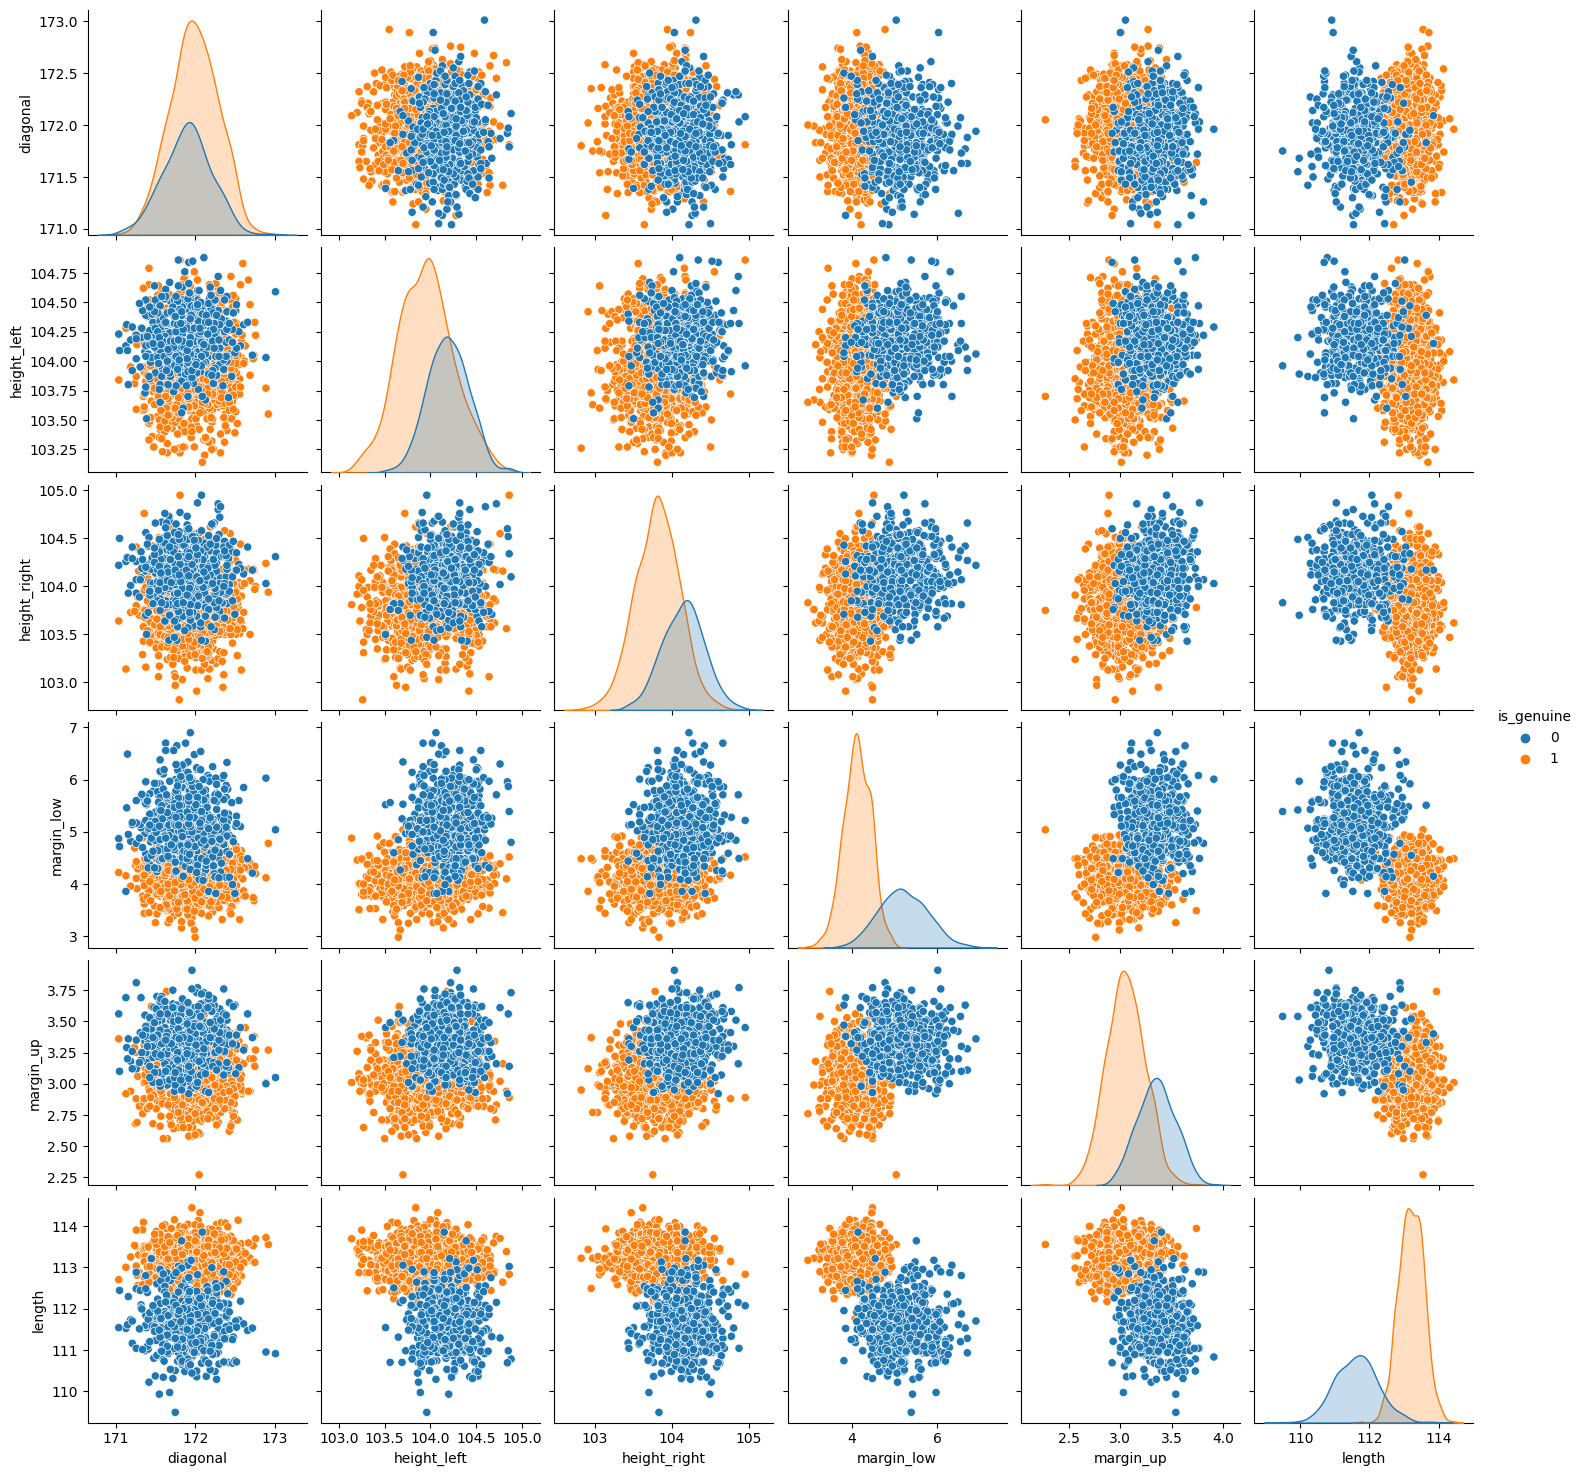

In [ ]:
import seaborn as sns
sns.pairplot(df, hue='is_genuine')
plt.show()

### Preprocesando datos

In [ ]:
X = df.iloc[:,1:7]
y = df.iloc[:,0]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X.to_numpy())
X = pd.DataFrame(X, columns=df.columns[1:])
X.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,0.390863,0.988506,1.000000,0.392857,0.378049,0.674747
1,0.213198,0.126437,0.394366,0.201531,0.439024,0.727273
2,0.837563,0.770115,0.319249,0.362245,0.408537,0.741414
3,0.162437,0.442529,0.525822,0.163265,0.451220,0.812121
4,0.350254,0.655172,0.300469,0.270408,0.737805,0.616162


### Conjuntos de entrenamiento y prueba

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Ajustando KNN

In [ ]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(x_train, y_train)
clf.score(x_train, y_train)

0.9904761904761905

In [ ]:
clf.score(x_test, y_test)

0.9844444444444445

In [ ]:
y_pred = clf.predict(x_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[137   6]
 [  1 306]]


In [ ]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       149
           1       0.99      0.99      0.99       301

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



### Mapa de calor

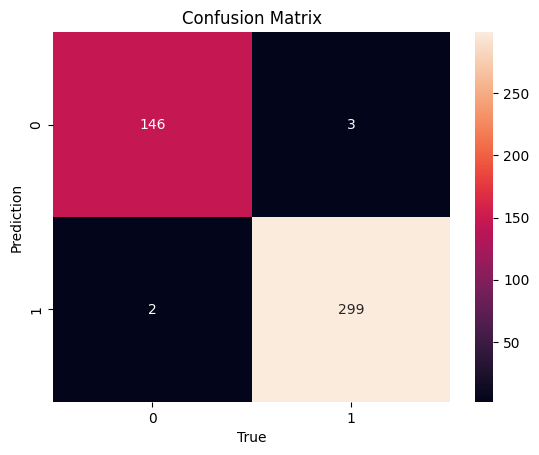

In [ ]:
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("True")
plt.ylabel("Prediction")
plt.title("Confusion Matrix")
plt.show()